# Basic usage of our library

In this notebook, we show some examples of how to use our library.
You can also start trying the library by just running `python scipts/ph_optimization.py`, 
which will run the library with the default parameters.

First of all, we need to add paths of the scripts.

In [ ]:
cur_dir = %pwd
if cur_dir.split("/")[-1] != "notebooks":
    %cd notebooks

In [2]:
%reload_ext autoreload
%autoreload 2
# %matplotlib ipympl

In [3]:
import sys
sys.path.append("..")
sys.path.append("../scripts")

## Table of Contents
1. [Generating the data](##Generating-the-data)
2. [Specifying the persistence-based loss](##Specifying-the-persistence-based-loss)
3. [Specifying the regularization](##Specifying-the-optimization-algorithm)
4. [How to use the optimization algorithms](##How-to-use-the-optimization-algorithms)
5. [Visualize the results](##Visualize-the-results)

## Generating the data

First, let us generate the point cloud to be optimized.
We generate a point cloud with 100 points in 2D with two circles and add some noise.

/home/nishikawa/anaconda3/envs/normal_env/lib/python3.10/site-packages/gudhi/persistence_graphical_tools.py:105: UserWarning: This function is not available.
ModuleNotFoundError: No module named 'matplotlib'.
  warnings.warn(f"This function is not available.\nModuleNotFoundError: No module named '{import_error.name}'.")


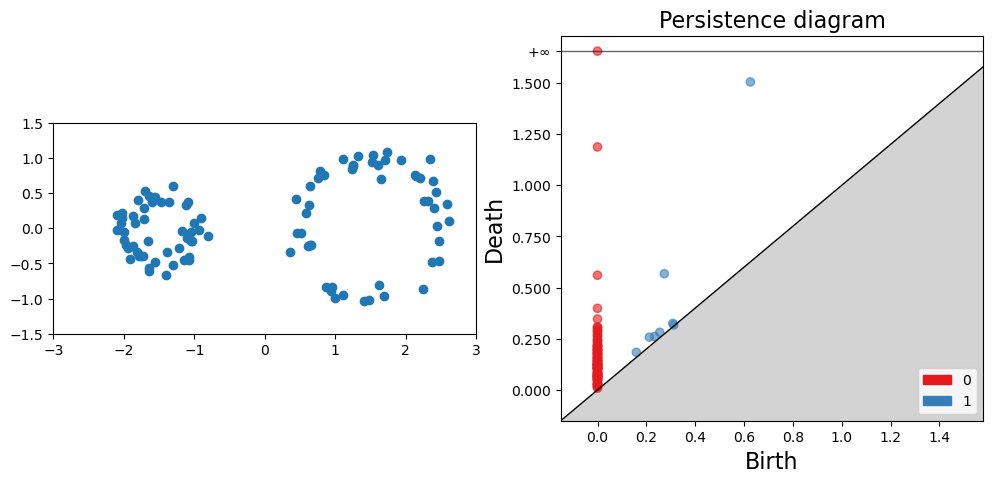

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from gudhi import plot_persistence_diagram
from gudhi.rips_complex import RipsComplex

### create data ###
num_pts = 100
small_num_pts, large_num_pts = num_pts//2, num_pts - num_pts//2
if os.path.isfile("simple_circle.npy"):
    X = np.load("simple_circle.npy")
else:
    theta = np.random.rand(small_num_pts) * 2 * np.pi
    small = np.array([-1.5 + 0.5 * np.cos(theta), 0.5 * np.sin(theta)]).T
    theta = np.random.rand(large_num_pts) * 2 * np.pi
    large = np.array([+1.5 + 1.0 * np.cos(theta), 1.0 * np.sin(theta)]).T
    X = np.concatenate([small, large], axis=0) + np.random.randn(num_pts, 2) * 0.1
    np.save("simple_circle.npy", X)

### visualize the data ###
fig = plt.figure(figsize=(12, 5))
# plot the point cloud
ax = fig.add_subplot(1, 2, 1)
ax.set_xlim(-3, 3); ax.set_ylim(-1.5, 1.5); ax.set_aspect('equal')
ax.scatter(X[:, 0], X[:, 1])
# plot the persistence diagram
ax = fig.add_subplot(1, 2, 2)
rips = RipsComplex(points=X[:, :])
dgms = rips.create_simplex_tree(max_dimension=2).persistence()
plot_persistence_diagram(dgms, legend=True, axes=ax)

plt.show()

## Specifying the persistence-based loss

Next, we describe the way to design the persistence-based loss.
In our library, persistence-based losses are implemented as instances of the `PersistenceBasedLoss` class.
Currently, we support the following loss functions:
- `WassersteinLoss`: the Wasserstein distance between two persistence diagrams.
    - Parameters:
        - `dim_list`(list[int]): the list of PD's dimensions to be considered.
        - `desirable_pd`(list[torch.Tensor]): the list of desirable PDs. The element `desirable_pd[i][j, 0]` and `desirable_pd[i][j, 1]` represent the birth and death of the `j`-th bar in the `i`-th dimension, respectively.
        - `order`(int, default=2): the order of the Wasserstein distance.
- `ExpandLoss`: the sum of the lengths of some bars in the persistence diagram.
    - Parameters:
        - `dim_list`(list[int]): the list of PD's dimensions to be considered.
        - `order`(int, default=1): the order of the Wasserstein distance.
        - `eps`(float, default=0.): if not `None`, the points in the PD with lifetime less than `eps` will be ignored.
        - `topk`(Optional[int], default=None): if not `None`, the points in PD are sorted by lifetime in descending order, and only the top k points are considered.

You can also implement your own loss function by inheriting the `PersistenceBasedLoss` class.
Please refer to `scripts/persistence_based_loss.py` or `notebooks/interface_for_comparison.ipynb` for the way to customize the loss function.
        
We use wasserstein distance as the loss function here.

In [5]:
from scripts.persistence_based_loss import WassersteinLoss
import torch

loss_obj = WassersteinLoss(dim_list=[1], desirable_pd=[torch.tensor([[0, 3]])], order=2)

## Specifying the regularization term

In this section, we describe the way to design the regularization term.
When implementing the class that represents the regularization term, we need to be careful about the following points:

- The class should inherit the `Regularization` class in `scripts/regularization.py`.
- We have to implement the `__call__` method, which takes a point cloud as input and returns the regularization term value.

If you want to use Continuation (or use `reg_proj=True` option in other methods), you also need to implement the `projection` method, which takes a point cloud as input and returns the projection of the point cloud onto the feasible set.

In this notebook, we implement the regularization term that that penalizes points in a point cloud for deviating from a circle of radius 3 centered at the origin.

In [6]:
import torch
from scripts.regularization import Regularization

class CircleRegularization(Regularization):
    def __init__(self, center: torch.Tensor, radius: float):
        self.center: torch.Tensor = center
        self.radius: float = radius
        assert self.center.shape == (2,)
    
    def __call__(self, X: torch.Tensor) -> torch.Tensor:
        return torch.sum(torch.relu(torch.norm(X - self.center, dim=1) - self.radius))
    
    ### The following is only necessary when you use Continuation (or use reg_proj=True option in GD/BigStep). ###
    def projection(self, X: torch.Tensor) -> torch.Tensor:
        if torch.all(torch.norm(X - self.center, dim=1)) <= self.radius:
            return X
        return self.center + self.radius * (X - self.center) / torch.norm(X - self.center, dim=1, keepdim=True)
    
reg_obj = CircleRegularization(center=torch.tensor([0, 0]), radius=3)

## How to use the optimization algorithms

Finally, let us apply the optimization algorithms to the loss and the regularization define above. 
Currently, we have three implemented algorithms: Gradient Descent, Continuation and Big Step.

- ***Gradient Descent*** is the most standard algorithm.
This algorithm just computes the gradient of the loss w.r.t. the coordinates of point clouds, and updates the coordinates in the opposite direction of the gradient.

- ***Continuation*** is a method proposed in [1] (see README.md for the references).
This method aims to track the point cloud when we move the points in PD to the desirable direction.
Unlike gradient descent, the direction of the update is not the gradient of the loss.
Therefore, continuation cannot take into account the regularization as a part of the loss function.
Instead, we project the point cloud onto the feasible set after each iteration.

- ***Big Step*** is a method proposed in [2].
This improves the gradient to make the loss less affected by the change of persistent pairs.

- ***Diffeo*** is a method proposed in [3].
They proposed the method to avoid the sparsity of the gradient by using differmorphic interpolation.

Each method corresponds to the class `GradientDescent`, `Continuation`, `BigStep` and `Diffeo` in `scripts/lib/ph_optimization_library.py`.
These classes inherit the `PHOptimization` class.
They can be initialized by `opt = GradientDecent(...)` (same for `Continuation`, `BigStep` and `Diffeo`).
If you want to update the point cloud, you just write `opt.update()`.
Here, we describe how to intinalize the classes.

### Common Settings 
You can specify the following parameters. 
- X(torch.Tensor): The point cloud to be optimized. Note that `X.requires_grad` must be `True`.
- loss_obj(PersistenceBasedLoss): The object to specify the loss function.
- reg_obj(Regularization): The object to specify the regularization term.
- lr(float): A constant to show how much the point cloud is updated in each iteration. For gradient descent, this corresponds to the learning rate.

### Settings except for `Continuation`
- reg_proj(bool, default=False): If `True`, the optimization algorithm will project the point cloud onto the feasible set after each iteration instead of adding the regularization term to the loss function.
- optimizer_conf(dict[str], default={"name": "SGD"}): A dictionary that represents the configuration of the optimizer. The dictionary has the following keys:
    - "name"(str): The name of the optimizer. Currently, we support "SGD" and "Adam".
- scheduler_conf(dict[str], default={"name": "const"}): A dictionary that represents the configuration of the scheduler. The dictionary has the following keys:
    - "name"(str): Name of the scheduler. You can choose from "const" and "TransformerLR".

### Settings only for `Diffeo`
- sigma(float, default=0.1): The parameter of the Gaussian kernel in the differmorphic interpolation.

### Settings only for `Continuation`
- in_iter_num(int, default=1): The number of iterations in the inner loop.

Now, we optimize the point cloud using the four algorithms above, and compare the results.

In [7]:
from scripts.lib.ph_optimization_library import GradientDescent, Continuation, BigStep, Diffeo

lr=1e-1
num_epoch=100

loss_history_list = [[], [], [], []]
X_history_list = [[], [], [], []]

In [8]:
print("=== Gradient Descent ===")
gd = GradientDescent(
    X = torch.tensor(X, dtype=torch.float32, requires_grad=True), 
    loss_obj=loss_obj, reg_obj=reg_obj, lr=lr
)
for epoch in range(num_epoch):
    loss_history_list[0].append(loss_obj(gd.X).item())
    X_history_list[0].append(gd.X.clone())
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss {gd.get_loss().item()}")
    gd.update()

=== Gradient Descent ===
Epoch 0, Loss 1.5022070407867432


/home/nishikawa/anaconda3/envs/normal_env/lib/python3.10/site-packages/torch/autograd/__init__.py:197: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525541990/work/c10/cuda/CUDAFunctions.cpp:109.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 10, Loss 1.21149742603302
Epoch 20, Loss 1.0738208293914795
Epoch 30, Loss 1.009595274925232
Epoch 40, Loss 0.8893448710441589
Epoch 50, Loss 0.8350022435188293
Epoch 60, Loss 0.7922185659408569
Epoch 70, Loss 0.748353123664856
Epoch 80, Loss 0.70506352186203
Epoch 90, Loss 0.6314564943313599


In [9]:
print("=== Continuation ===")
continuation = Continuation(
    X = torch.tensor(X, dtype=torch.float32, requires_grad=True), 
    loss_obj=loss_obj, reg_obj=reg_obj, lr=lr, in_iter_num=1
)
for epoch in range(num_epoch):
    loss_history_list[1].append(loss_obj(continuation.X).item())
    X_history_list[1].append(continuation.X.clone())
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss {continuation.get_loss().item()}")
    continuation.update()

=== Continuation ===
Epoch 0, Loss 1.5022070407867432
Epoch 10, Loss 1.2334736585617065
Epoch 20, Loss 1.1688578128814697
Epoch 30, Loss 1.1185760498046875
Epoch 40, Loss 1.0718320608139038
Epoch 50, Loss 1.0140544176101685
Epoch 60, Loss 0.9807707071304321
Epoch 70, Loss 0.9492017030715942
Epoch 80, Loss 0.9087291359901428
Epoch 90, Loss 0.8809469938278198


In [10]:
print("=== Big Step ===")
bigstep = BigStep(
    X = torch.tensor(X, dtype=torch.float32, requires_grad=True), 
    loss_obj=loss_obj, reg_obj=reg_obj, lr=lr
)
for epoch in range(num_epoch):
    loss_history_list[2].append(loss_obj(bigstep.X).item())
    X_history_list[2].append(bigstep.X.clone())
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss {bigstep.get_loss().item()}")
    bigstep.update()

=== Big Step ===
Epoch 0, Loss 1.5022070407867432
Epoch 10, Loss 1.0703766345977783
Epoch 20, Loss 0.9602614641189575
Epoch 30, Loss 1.0769530534744263
Epoch 40, Loss 0.9669011235237122
Epoch 50, Loss 0.7493462562561035
Epoch 60, Loss 0.6566651463508606
Epoch 70, Loss 0.5433815717697144
Epoch 80, Loss 0.525697648525238
Epoch 90, Loss 0.5175783634185791


In [11]:
print("=== Diffeo ===")
diffeo = Diffeo(
    X = torch.tensor(X, dtype=torch.float32, requires_grad=True), 
    loss_obj=loss_obj, reg_obj=reg_obj, lr=lr, sigma=0.3
)
for epoch in range(num_epoch):
    loss_history_list[3].append(loss_obj(diffeo.X).item())
    X_history_list[3].append(diffeo.X.clone())
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss {diffeo.get_loss().item()}")
    diffeo.update()

=== Diffeo ===
Epoch 0, Loss 1.5022070407867432
Epoch 10, Loss 1.2211722135543823
Epoch 20, Loss 1.0232961177825928
Epoch 30, Loss 0.8391799330711365
Epoch 40, Loss 0.7234950661659241
Epoch 50, Loss 0.6518568396568298
Epoch 60, Loss 0.6091368794441223
Epoch 70, Loss 0.6133170127868652
Epoch 80, Loss 0.4812532365322113
Epoch 90, Loss 0.4558940529823303


## Visualize the results

Finally, we obtain the animation that summarized the optimization history.
We can do this with the use of the function `get_animation` in `scripts/lib/visualization.py`.

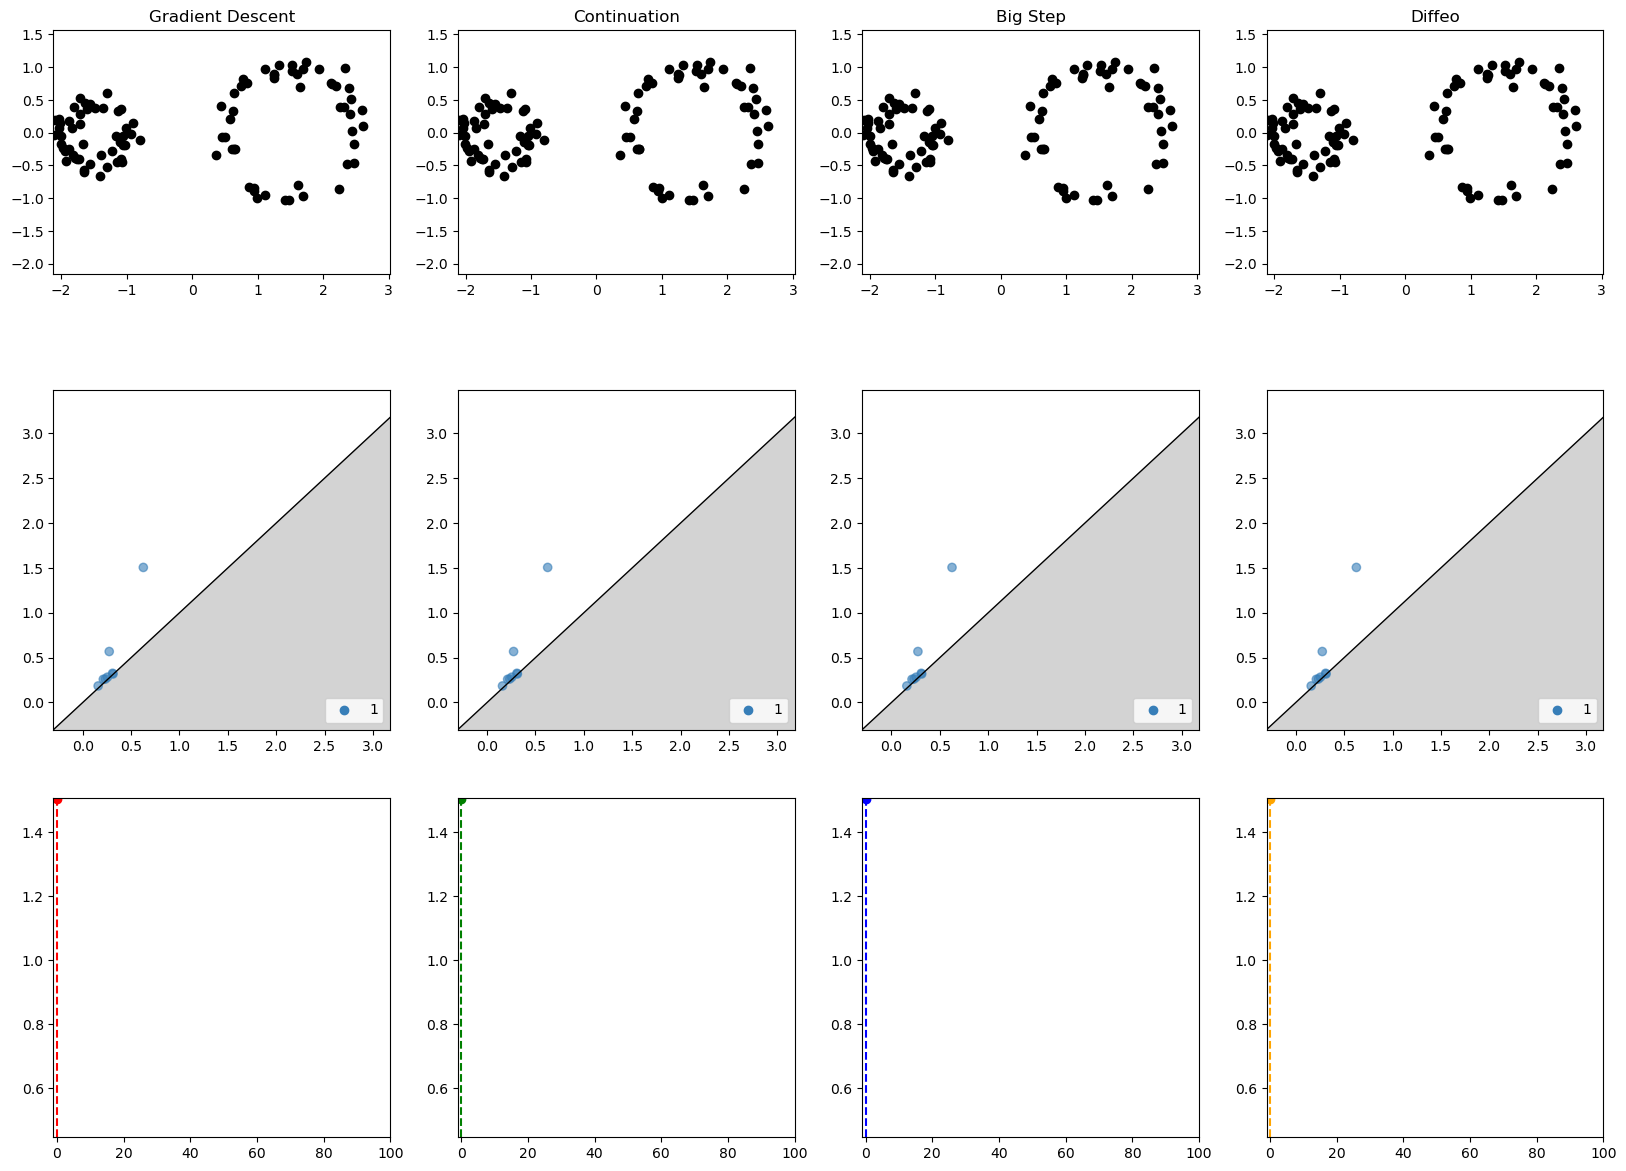

In [13]:
from scripts.lib.visualization import get_animation

title_list = ["Gradient Descent", "Continuation", "Big Step", "Diffeo"]
loss_history = [[obj] for obj in loss_history_list]
ani = get_animation(X_history_list, loss_history, dim_list=[1], title_list=title_list)
ani.save("animation.gif", writer="pillow", fps=10)